# An RL application: managing the powergrid

During this session we present an application to reinforcement learning in a "real world" scenario.

During this lecture, you will learn the (ultra) basic of powergrid operation (*ie* what some people are doing 24/7 to ensure the rest of the world has access to as much power as possible). 

You will also be able to interact with a powergrid and see how to apply some (state of the art?) algorithm to solve these problems.

**Disclaimer**: This notebook presents the "powergrid problem" in a very simplified version. This "powergrid problem" (as modelized for the l2rpn competitions [Robustness](https://competitions.codalab.org/competitions/25426) and [Adaptability](https://competitions.codalab.org/competitions/25427)) is itself only a small part of what powergrid operators need to do in real time. This notebook does not pretend at all to be exhaustive in the description of all of these problematics.


## Problem statement


### 1) Introduction to powergrid
For this notebook we will use a dedicated environment called "educ_case14_redisp". Grid2op comes with many different environments, with different problems etc. In this notebook, we will only mention and explain this specific environment.

Power system have one major objective: allow the transmission of electricity from the producers to the consumers as effeciently as possible.

This environment is based on the "IEEE case14" grid studied in the litterature.

This grid counts 20 power lines (represented in the figure bellow by the black line), 11 loads (each one representing a city or a big industrial consumer) represented by the triangles in the figure bellow and 6 different generators.

Then generators are represented by pentagons. In reality, and as modeled by our environments, generators have varying properties depending on their types. In this environment there are 2 solars generators (in dark orange), 1 hydro generator (in dark blue), 1 nuclear generator (in yellow) and one "thermal" generator (you can imagine powered by coal or natural gas) in violet. 

/home/benjamin/Documents/grid2op_dev/getting_started/grid2op/MakeEnv/Make.py:266: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


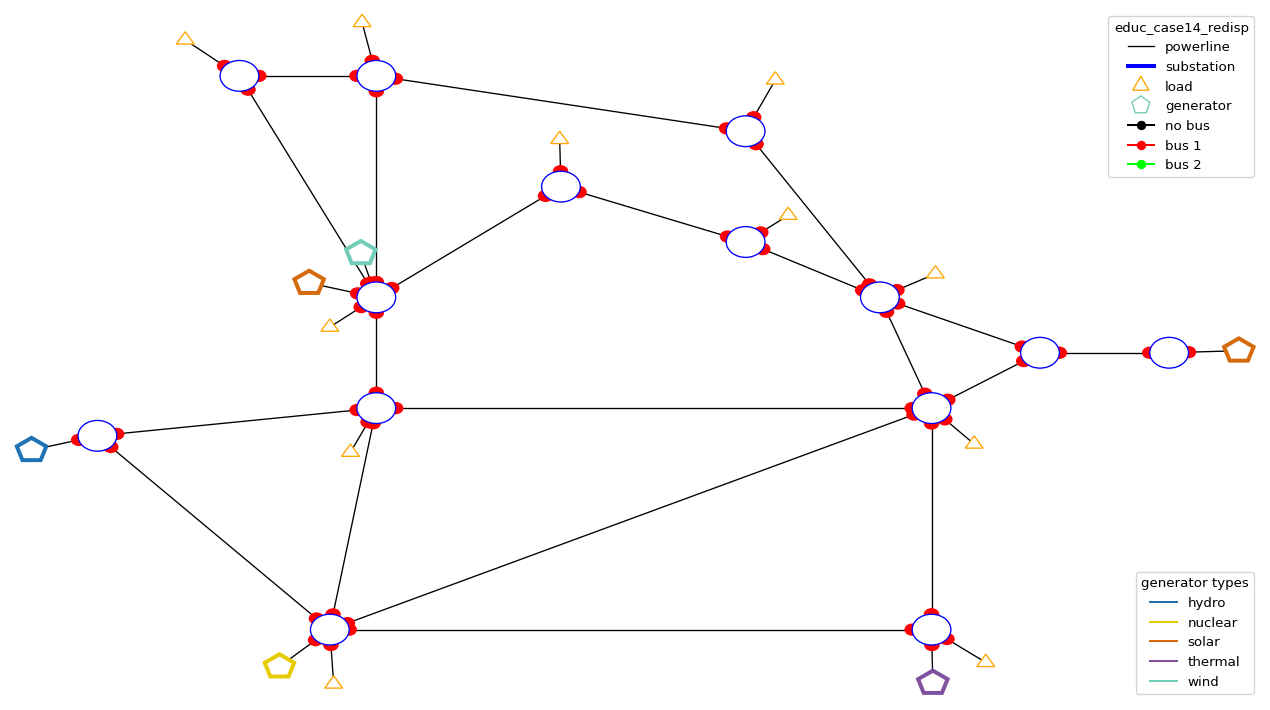

In [12]:
import numpy as np  # 99% of python scripts (for data science) use this package
import grid2op  # main package
from grid2op.PlotGrid import PlotMatplot  # for representing (plotting) the grid
env = grid2op.make("educ_case14_redisp", test=True)  # creating the environment (compatible with openai gym)
plot_helper = PlotMatplot(env.observation_space)
fig = plot_helper.plot_gen_type()

**GOAL**: The goal of the "game" you will play is the following: given some phyiscal constraints (more on that on the next section) your agent will need to adjust the productions of the dispatchable generators as to minimize the  "margin" of each powerline on the grid.

### 2) Definition of the reward

#### The joule's effect and the sag
In reality, each powerline cannot transmit an infinite amount of power. 

Due to some constraints: for example, when too much current pass on a line, because of the Joule's effect, this powerline heats. And because powerlines are made in metal, when they heat they inflate and so get closer to the ground... or... your house...

This phenomenon is illustrated in the figure below:

The flow is relatively small, the powerline is far above the tree
![title](img/sag0.jpg)

The flow increases, the powerline gets closer to the tree
![title](img/sag1.jpg)

The flow is too high, the powerline gets closer even closer to the tree and ends up touching it
![title](img/sag2.jpg)

Which can, in the best case break the powerline or, depending on the season, the weather, etc. set aflame a whole part of a state (this is the cause of some of the fire in California in 2020) possibly killing dozens of people.


#### Thermal limits and protections

To avoid being in such trouble, companies operating powergrids, often set up some limits on the flows that can be transmitted on the powergrid. For the sake of the example, we displayed the this limit (called thermal limit) on each powerline on the grid in the next cell.

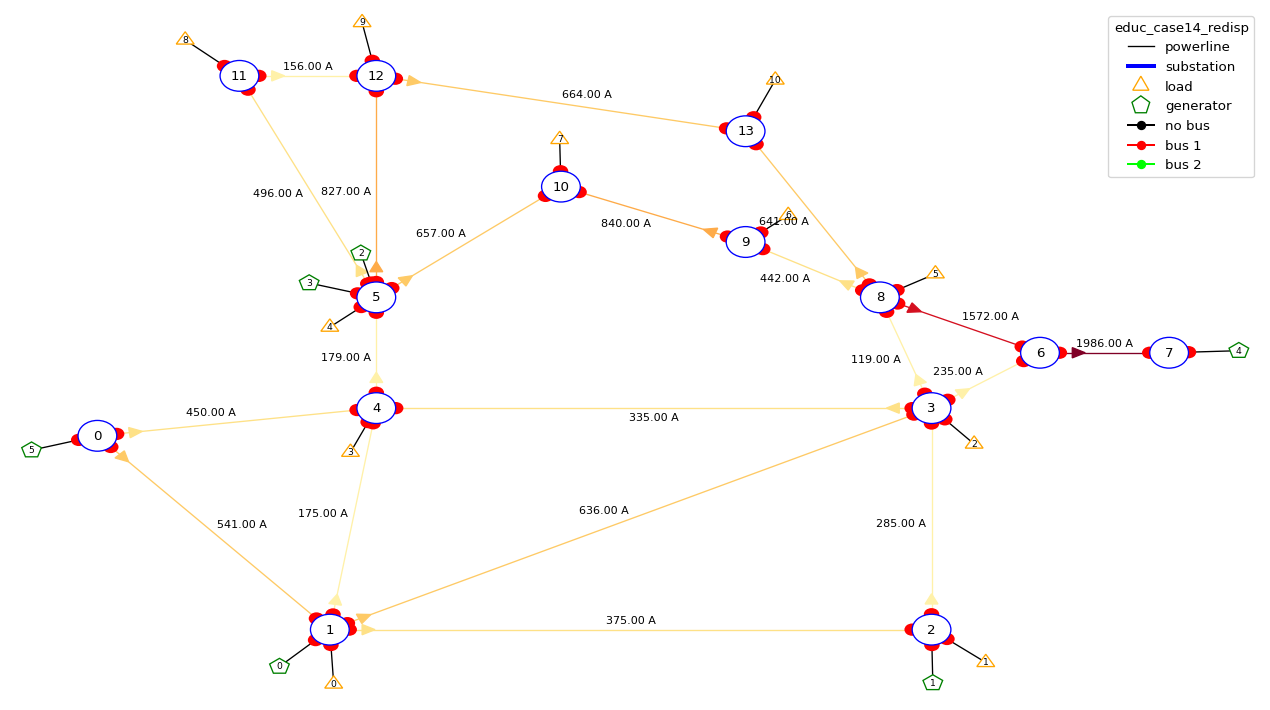

In [20]:
plot_helper.assign_line_palette()  # get a prettier coloring for the powerlines
_ = plot_helper.plot_info(line_values=env.get_thermal_limit(), coloring="line", line_unit="A")
plot_helper.restore_line_palette()

And to be certains that the flows stays below these limits, every powerlines (on our simplified setting) is equiped with some "protections".

The detailed functionning of these protections is out of the scope of this lecture, but the principle is rather simple. A protection is a piece of equipment that will automatically disconnect a powerline if it detects some danger.

For this environment these "protections" will automatically disconnect some powerlines when:

- the flow on the powerline is above the thermal limit for too long (3 consecutive steps)
- the flow on the powerline is exceed twice the thermal limit (in this case the disconnection is instanteneous)

#### Margin on a powerline

Now that we know the current is limited, we can properly define the "margin" on a powerline. The margin can be thought as the amount of current that the powerline can still transmit without any danger.

More formally, if we denote by `i` the current on a given powerline and by `M` its thermal limit then the margin is defined as, for this environment as:
```
relative_flow = i / M
raw_margin = 1 - i / M
raw_margin_capped = max(0., raw_margin)  # to ensure the margin is between 0 and 1
margin_powerline = raw_margin_capped^2
```

The "reward" of this game is then the sum of all the `margin_powerline` for all powerline of the grid. Note that if a powerline is disconnected, with this setting its margin is 1.0 (there is no powerflow on it) and if the powerline is on overflow (the flow `i` is equal or above the thermal limit `M`) the the margin is 0.0, which make sense because in this case, you can't have any more flows on this powerline.


### 3) Game over
So now we have defined what we need to do: at any time we need to maximise the total margin of the grid. This corresponds to taking as less risk as possible during the powergrid operations.


#### Game over conditions
But as we saw, a pretty simple "policy" would solve this problem very easily. As we explained above, when a powerline is disconnected from the grid, then the margin on this powerline is 1.0, which is the highest possible margin. The policy consisting in "disconnecting every powerline" would then be extremely efficient. This makes total sense: if everything is disconnected, the no power is flowing and everything is safe [this is often why I would recommend to switch off the house circuit breaker before trying to touch any powerplug in your house.]

But this solution is not satisfactory. The goal of the powergrid is indeed to bring power to as much people / companies as possible. In our framework grid2op we modeled this phenomenon by introducing some "game over" criteria. And, when the game is over, you lost the game.

To be perfectly exhaustive, there are 4 game over conditions for this environment at the moment:

- a load is disconnected from the grid
- a generator is disconnected from the grid
- the grid is split into independant part
- some technical conditions imposed by the solving of the powerflow equations (out of scope)


#### Operate in safety


In [21]:
nb_ts = []
from grid2op.Agent import DoNothingAgent
agent = DoNothingAgent(env.action_space)
for i in range(7):
    obs = env.reset()
    reward = env.reward_range[0]
    done = False
    ts = 0
    while not done:
        act = agent.act(obs, reward, done)
        obs, reward, done, info = env.step(act)
        ts += 1
    nb_ts.append(ts)